In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

# Correct dataset structure should be:
# /kaggle/input/wheat1/
# ├── Class1/
# │   ├── img1.jpg
# │   └── img2.jpg
# ├── Class2/
# │   ├── img1.jpg
# └── ...

dataset_path = "/kaggle/input/plant-disease-dataset/dataset_flat"



In [2]:
# Create proper train/validation/test splits (70-15-15)
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3  # 30% for validation + test
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.5  # Split validation into test (50% of 30% = 15%)
)

# Train generator (70%)
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Validation generator (15%)
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

# Test generator (15%)
test_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

Found 66910 images belonging to 56 classes.
Found 28653 images belonging to 56 classes.
Found 47775 images belonging to 56 classes.


In [3]:
# Build model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = False

# Add custom head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Initial training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1046/1046 ━━━━━━━━━━━━━━━━━━━━ 2176s 2s/step - accuracy: 0.5916 - loss: 1.4128 - val_accuracy: 0.8517 - val_loss: 0.4298
Epoch 2/10
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 1792s 2s/step - accuracy: 0.8389 - loss: 0.4625 - val_accuracy: 0.8714 - val_loss: 0.4095
Epoch 3/10
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 1776s 2s/step - accuracy: 0.8722 - loss: 0.3669 - val_accuracy: 0.8803 - val_loss: 0.4035
Epoch 4/10
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 1797s 2s/step - accuracy: 0.8787 - loss: 0.3449 - val_accuracy: 0.8867 - val_loss: 0.3519
Epoch 5/10
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 1793s 2s/step - accuracy: 0.8916 - loss: 0.3174 - val_accuracy: 0.8976 - val_loss: 0.3268
Epoch 6/10
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 1762s 2s/step - accuracy: 0.8973 - loss: 0.2964 - val_accuracy: 0.8982 - val_loss: 0.3445
Epoch 7/10
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 1776s 2s/step - accuracy: 0.9046 - loss: 0.2794 - val_accuracy: 0.9028 - val_loss: 0.3488
Epoch 8/10
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 1721s 2s/step - accuracy: 0.9064 - loss: 0.26

In [4]:
# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 1837s 2s/step - accuracy: 0.9226 - loss: 0.2244 - val_accuracy: 0.9171 - val_loss: 0.3075
Epoch 2/5
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 1950s 2s/step - accuracy: 0.9406 - loss: 0.1648 - val_accuracy: 0.9165 - val_loss: 0.3114
Epoch 3/5
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 1853s 2s/step - accuracy: 0.9452 - loss: 0.1534 - val_accuracy: 0.9204 - val_loss: 0.3098
Epoch 4/5
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 1786s 2s/step - accuracy: 0.9493 - loss: 0.1435 - val_accuracy: 0.9209 - val_loss: 0.3085
Epoch 5/5
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 1763s 2s/step - accuracy: 0.9537 - loss: 0.1316 - val_accuracy: 0.9216 - val_loss: 0.3037


In [5]:
# Evaluation
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

747/747 ━━━━━━━━━━━━━━━━━━━━ 454s 607ms/step - accuracy: 0.9098 - loss: 0.4739

Final Test Accuracy: 94.53%
Final Test Loss: 0.2147


In [6]:
# Classification Report
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_names))

747/747 ━━━━━━━━━━━━━━━━━━━━ 443s 589ms/step
                                  precision    recall  f1-score   support

               Corn__common_rust       1.00      0.70      0.82       762
            Corn__gray_leaf_spot       0.68      0.90      0.78       774
                   Corn__healthy       1.00      1.00      1.00       803
      Corn__northern_leaf_blight       0.79      0.54      0.64       773
                   Cotton Aphids       1.00      0.99      1.00       982
                Cotton Army worm       0.99      1.00      1.00       969
         Cotton Bacterial blight       0.99      0.99      0.99       937
                  Cotton Healthy       0.99      1.00      1.00       949
           Cotton Powdery mildew       1.00      0.99      1.00       890
              Cotton Target spot       0.98      0.98      0.98       843
                 Grape Black Rot       1.00      0.98      0.99       944
                      Grape ESCA       0.98      1.00      0.99   

In [7]:
# Save the model in .keras format
model.save("/kaggle/working/plant_disease_model.keras")

# Save in .h5 format for compatibility
model.save("/kaggle/working/plant_disease_model.h5")

In [8]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model("/kaggle/working/plant_disease_model.keras")

# Verify by evaluating on test data
test_loss, test_acc = loaded_model.evaluate(test_generator)
print(f"\nLoaded Model Test Accuracy: {test_acc*100:.2f}%")

747/747 ━━━━━━━━━━━━━━━━━━━━ 424s 561ms/step - accuracy: 0.9098 - loss: 0.4739

Loaded Model Test Accuracy: 94.53%


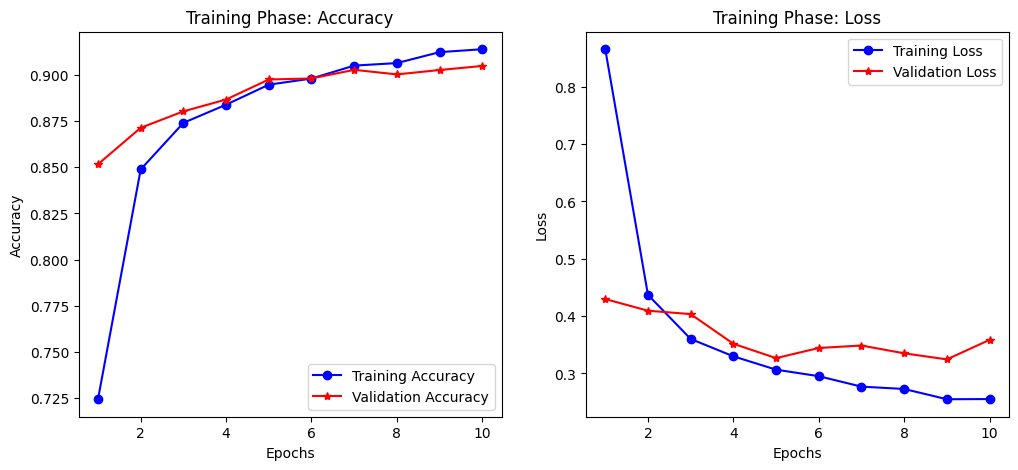

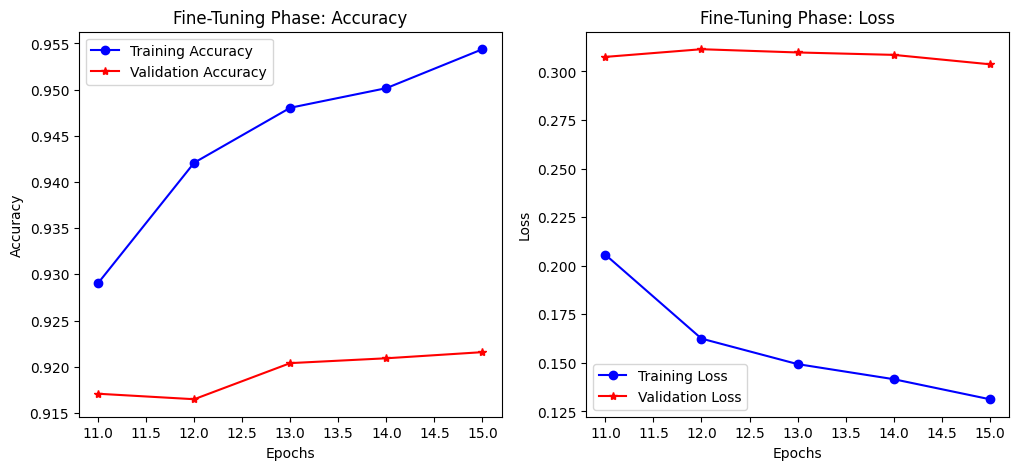

In [9]:
import matplotlib.pyplot as plt

# Extract training and fine-tuning history separately
train_epochs = len(history.history['accuracy'])  # Should be 20
fine_tune_epochs = len(history_fine.history['accuracy'])  # Should be 10

# Training phase data (First 20 epochs)
train_acc = history.history['accuracy']
train_val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
train_epochs_range = range(1, train_epochs + 1)

# Fine-tuning phase data (Last 10 epochs)
fine_tune_acc = history_fine.history['accuracy']
fine_tune_val_acc = history_fine.history['val_accuracy']
fine_tune_loss = history_fine.history['loss']
fine_tune_val_loss = history_fine.history['val_loss']
fine_tune_epochs_range = range(train_epochs + 1, train_epochs + fine_tune_epochs + 1)

# Plot Training Phase
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_epochs_range, train_acc, 'bo-', label='Training Accuracy')
plt.plot(train_epochs_range, train_val_acc, 'r*-', label='Validation Accuracy')
plt.title('Training Phase: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_epochs_range, train_loss, 'bo-', label='Training Loss')
plt.plot(train_epochs_range, train_val_loss, 'r*-', label='Validation Loss')
plt.title('Training Phase: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plot Fine-Tuning Phase
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_epochs_range, fine_tune_acc, 'bo-', label='Training Accuracy')
plt.plot(fine_tune_epochs_range, fine_tune_val_acc, 'r*-', label='Validation Accuracy')
plt.title('Fine-Tuning Phase: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fine_tune_epochs_range, fine_tune_loss, 'bo-', label='Training Loss')
plt.plot(fine_tune_epochs_range, fine_tune_val_loss, 'r*-', label='Validation Loss')
plt.title('Fine-Tuning Phase: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()